### Mestrado Profissional em Computação Aplicada

#### **Disciplina**: Redes Neurais Artificiais 
####  **Professor**: Dr. Francisco de Assis Boldt
#### **Aluno**: Adriel Monti De Nardi

------



### Trabalho 04: Testar a ELM com validação de treino e teste

Para concluir a proposta desta atividade, será verificado o desempenho da ELM criando um novo dataset, usando a mesma função de criação do dataset.



#Função gera dataset, plota dataset e hiperplano

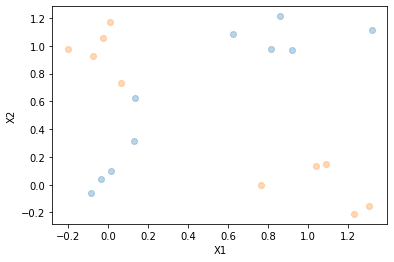

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0])

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def geradataset(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]]):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.2)
    y = np.array(y%2, dtype=int)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

X, y = geradataset()
plotadataset(X, y)
plt.show()
y

#Funções de Custo


In [3]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

#Algoritmos

In [4]:
class DescidaGradiente():
    def __init__(self, custo=Adaline(), maxiter=1000, alpha=0.005):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
    
    def getW(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, -1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            w = w + self.alpha * self.custo.gradiente(y, ypred, X)
        return w

class PseudoInversa():
    def __init__(self):
        pass
    def getW(self, X, y):
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

#Extreme Learning Machine

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

def tanh(a):
    return expit(a) * 2 - 1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    def __init__(self, algoritmo=PseudoInversa()):
        self.wih = None
        self.w = None
        self.threshold = 0
        self.activation = tanh
        self.algoritmo = algoritmo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1],X.shape[0]//3))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getW(X, y, self.activation)
        else:
            self.w = self.algoritmo.getW(X, y)

    def predict(self, X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        Xb = ExtremeLearningMachine.includebias(Xho)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

#Treino

In [9]:
elm = ExtremeLearningMachine()
elm.fit(X, y)
ypred = elm.predict(X)
print(sum(y == ypred)/len(y))

1.0


#Plotting Decision Regions

Aqui será plotado a região de decisão da ELM 

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


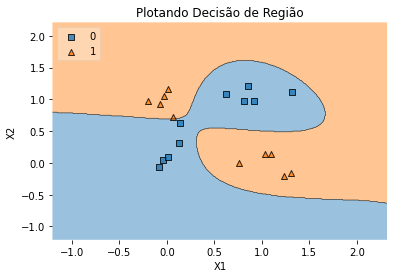

In [10]:
from mlxtend.plotting import plot_decision_regions
!pip install mlxtend 


plot_decision_regions(X, ypred, clf=elm, legend=len(set(y)))
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("Plotando Decisão de Região")
plt.show()

#Teste
Agora, será verificado o desempenho da ELM criando um novo dataset, usando a mesma função de criação do dataset.

In [11]:
# Teste com amostras fora do treinamento
Xte, yte = geradataset(10000)
ypred = elm.predict(Xte)
print(sum(yte == ypred)/len(yte))

0.9491


Plotting Decision Regions (fora do treinamento)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


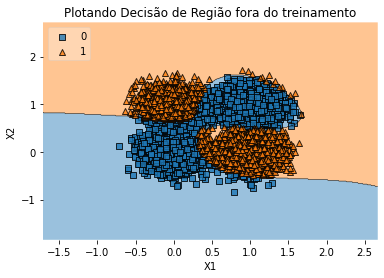

In [13]:
from mlxtend.plotting import plot_decision_regions
!pip install mlxtend 


plot_decision_regions(Xte, ypred, clf=elm, legend=len(set(yte)))
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("Plotando Decisão de Região fora do treinamento")
plt.show()

#Referência:

- [Como faço para instalar pacotes Python no Colab do Google?](https://qastack.com.br/programming/51342408/how-do-i-install-python-packages-in-googles-colab) (data de acesso: 01.09.2021)
- [Installing mlxtend](http://rasbt.github.io/mlxtend/installation/) (data de acesso: 01.09.2021)
- [Plotting Decision Regions](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/)
(data de acesso: 01.09.2021)

